In [158]:
client.close()

In [1]:
from plotnine import *
import numpy as np
import datetime

In [2]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:42919 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 24 Memory: 31.33 GiB


In [3]:
which_device='C'

In [4]:
df = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}.parquet/')
df.head()

,time,y_diff,emf,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,input_excitation
0,0.000,0.040000,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0
1,0.003,0.040022,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0
2,0.006,0.040088,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0
3,0.009,0.040195,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0
4,0.012,0.040343,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0


In [5]:
# Get the unique_model_ids once (we'll be using this to filter the larger file later)
unique_model_ids = df['model_id'].unique().compute().values
unique_model_ids

array([3240, 3241, 3242, ..., 6261, 6262, 6263])

In [8]:
from unified_model import evaluate
from unified_model.utils.utils import collect_samples

BASE_GROUNDTRUTH_PATH = '../data/2019-05-23_D/'
samples = {}
samples['A'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='C/*labels*.csv')

from unified_model.mechanical_components import MagnetAssembly
magnet_assembly = MagnetAssembly(m=1,
                                 l_m_mm=10,
                                 l_mcd_mm=0,
                                 dia_magnet_mm=10,
                                 dia_spacer_mm=10,
                                 mat_magnet='NdFeB',
                                 mat_spacer='iron')


samples_list = samples[which_device]

gtf = evaluate.GroundTruthFactory(
    samples_list=samples_list,
    lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                seconds_per_frame=1 / 60,  # noqa
                pixel_scale=0.154508),
    adc_kwargs=dict(voltage_division_ratio=1 / 0.342))  # noqa

gt = gtf.make()
len(gt)

8

In [9]:
from unified_model.metrics import dtw_euclid_distance, similarity_measure
from scipy.stats import zscore
# Define some other metrics for completeness

def dtw_euclid_norm(x1, x2):
    return dtw_euclid_distance(x1/np.max(x1), x2/np.max(x2))

def dtw_euclid_z_norm(x1, x2):
    return dtw_euclid_distance(zscore(x1), zscore(x2))

def _joint_z_norm(x1, x2):
    # http://luscinia.sourceforge.net/page26/page14/page14.html
    joint_mean = np.sum([x1, x2])/(len(x1) + len(x2))
    x1_joint_std = np.sum((x1 - joint_mean)**2)
    x2_joint_std = np.sum((x2 - joint_mean)**2)
    joint_std = np.sqrt((x1_joint_std + x2_joint_std)/(len(x1) + len(x2) - 1))
    
    x1_norm = (x1-joint_mean)/joint_std
    x2_norm = (x2-joint_mean)/joint_std
    return x1_norm, x2_norm

def dtw_euclid_joint_z_norm(x1, x2):
    x1_norm, x2_norm = _joint_z_norm(x1, x2)
    return dtw_euclid_distance(x1_norm, x2_norm)

In [10]:
import ray

x = [1 ,2 3]

In [11]:
@ray.remote
def calc_metrics(df_slice, ground_truth, emf_metrics_dict):
    time_predict = df_slice['time'].values
    emf_predict = df_slice['emf'].values

    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=ground_truth.elec.emf,
        time_target=ground_truth.elec.time,
        metrics=emf_metrics_dict
    )
    elec_eval.fit(
        emf_predict=emf_predict,
        time_predict=time_predict
    )
    score = elec_eval.score()
    return score

In [12]:
ray.shutdown()

In [13]:
ray.init()

2021-04-27 11:01:03,186	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.140',
 'raylet_ip_address': '192.168.0.140',
 'redis_address': '192.168.0.140:6379',
 'object_store_address': '/tmp/ray/session_2021-04-27_11-01-02_340065_4980/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-27_11-01-02_340065_4980/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-27_11-01-02_340065_4980',
 'metrics_export_port': 57197,
 'node_id': 'e5a779826797338a4de51fb9b59f0179434c3ecfad2b85bedd607f79'}

In [45]:
from tqdm.notebook import tqdm

emf_metrics_dict = {'emf_similarity': similarity_measure,
                     'emf_dtw_euclid_norm': dtw_euclid_norm,
                     'emf_dtw_euclid_z_norm': dtw_euclid_z_norm,
                     'emf_dtw_euclid_joint_z_norm': dtw_euclid_joint_z_norm,
                     'emf_dtw_dist': dtw_euclid_distance} 

model_id_list = []
input_list = []
similarity_scores_list = []

input_numbers = range(len(samples_list))

print('Submitting to Ray...')
for input_ in tqdm(input_numbers[4:]):
    print(f'Processing for input={input_}')
    df = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}.parquet/', columns=['time', 'emf', 'model_id', 'input_excitation'], filters=[('input_excitation', '=', input_)]).compute()
    remaining_refs = []
    ready_refs = []
    for model_id in tqdm(unique_model_ids):
        df_slice = df.query(f'model_id == {model_id}').sort_values(by='time')
        ground_truth = gt[input_]
        remaining_refs.append(calc_metrics.remote(df_slice, ground_truth, emf_metrics_dict))
        
        # Must fit the shape of the original dataframe series
        model_id_list.append(model_id)
        input_list.append(input_)
    print('Polling for completed results...')
    while len(ready_refs) < len(unique_model_ids):  # Wait for all our model_ids to get processed
        ready_refs, remaining_refs = ray.wait(remaining_refs, num_returns=len(unique_model_ids), timeout=30)
        print(f'{datetime.datetime.now()} :: Remaining: {len(remaining_refs)}')
           
    print('Fetching results...')
    for ref in tqdm(ready_refs):
        similarity_scores_list.append(ray.get(ref))

Submitting to Ray...


  0%|          | 0/4 [00:00<?, ?it/s]

Processing for input=4


  0%|          | 0/7500 [00:00<?, ?it/s]

Polling for completed results...
2021-04-27 14:23:05.063259 :: Remaining: 0
Fetching results...


  0%|          | 0/7500 [00:00<?, ?it/s]

Processing for input=5


  0%|          | 0/7500 [00:00<?, ?it/s]

Polling for completed results...
2021-04-27 14:29:11.146798 :: Remaining: 0
Fetching results...


  0%|          | 0/7500 [00:00<?, ?it/s]

Processing for input=6


  0%|          | 0/7500 [00:00<?, ?it/s]

Polling for completed results...
2021-04-27 14:36:40.252357 :: Remaining: 0
Fetching results...


  0%|          | 0/7500 [00:00<?, ?it/s]

Processing for input=7


  0%|          | 0/7500 [00:00<?, ?it/s]

Polling for completed results...
2021-04-27 14:43:04.045874 :: Remaining: 0
Fetching results...


  0%|          | 0/7500 [00:00<?, ?it/s]

In [46]:
from collections import defaultdict

In [47]:
scores_dict = defaultdict(lambda: [])  # So we don't have to add a list first
for s in similarity_scores_list:
    for k,v in s.items():
        scores_dict[k].append(v)

In [48]:
scores_dict['model_id'] = model_id_list
scores_dict['input_excitation'] = input_list

In [49]:
import pandas as pd

df_test = pd.DataFrame(scores_dict)
df_test

,emf_similarity,emf_dtw_euclid_norm,emf_dtw_euclid_z_norm,emf_dtw_euclid_joint_z_norm,emf_dtw_dist,model_id,input_excitation
0,0.902975,192.905258,673.289913,811.618731,89.111566,3240,4
1,0.911594,184.243880,469.118793,803.377280,90.242777,3241,4
2,0.935795,116.598632,482.747132,623.681603,71.873191,3242,4
3,0.940083,147.118075,641.176378,737.864235,82.938760,3243,4
4,0.940550,129.336073,702.325869,773.890352,89.434100,3244,4
...,...,...,...,...,...,...,...
29995,0.969943,65.327738,495.467462,491.761127,58.885429,6259,7
29996,0.907712,114.643210,658.591194,826.624263,91.332820,6260,7
29997,0.936014,78.072014,431.588357,647.534685,71.628058,6261,7
29998,0.928348,72.407510,623.343930,760.329452,86.916331,6262,7


In [50]:
df_melt = df_test.drop(columns=['model_id', 'input_excitation']).melt(id_vars='emf_dtw_dist')
df_melt.head()

,emf_dtw_dist,variable,value
0,89.111566,emf_similarity,0.902975
1,90.242777,emf_similarity,0.911594
2,71.873191,emf_similarity,0.935795
3,82.938760,emf_similarity,0.940083
4,89.434100,emf_similarity,0.940550


/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


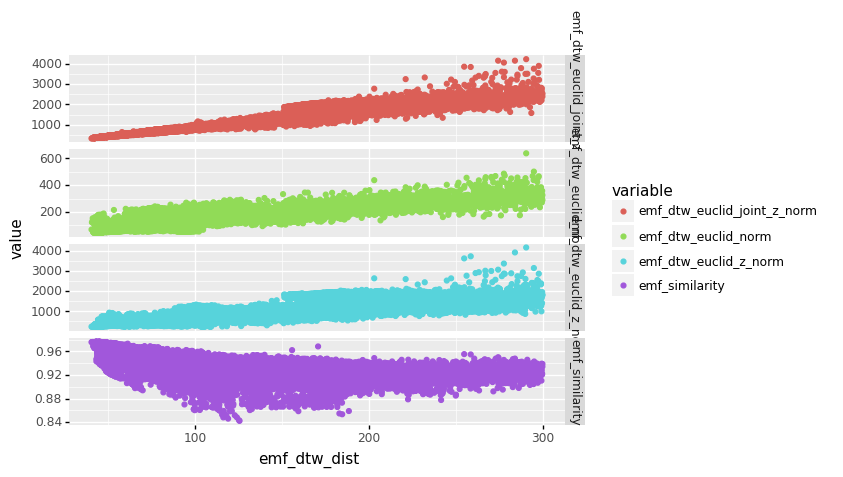

<ggplot: (8753998880409)>

In [51]:
p = ggplot(aes(x='emf_dtw_dist', y='value', color='variable'), df_melt.query('emf_dtw_dist < 300'))
p + geom_point() + facet_grid('variable ~ .', scales='free')

In [52]:
df_test.to_parquet(f'../data/parameter_search/2021-03-19/{which_device}_similarity.parquet')

In [53]:
df_test = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}_similarity.parquet')
df_test

,emf_similarity,emf_dtw_euclid_norm,emf_dtw_euclid_z_norm,emf_dtw_euclid_joint_z_norm,emf_dtw_dist,model_id,input_excitation
npartitions=1,,,,,,,
,float64,float64,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...


In [54]:
df = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}.parquet/')
df['input_excitation'] = df['input_excitation'].astype(int)

In [55]:
df_merge = df.merge(df_test, how='inner', on=['model_id', 'input_excitation'])
df_merge.to_parquet(f'../data/parameter_search/2021-03-19/{which_device}_sim_p2.parquet', partition_on='input_excitation', compression='brotli')

In [56]:
df_merge = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}_sim_p2.parquet')
df_merge.head()

,time,y_diff,emf,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,emf_similarity,emf_dtw_euclid_norm,emf_dtw_euclid_z_norm,emf_dtw_euclid_joint_z_norm,emf_dtw_dist,input_excitation
0,0.000,0.040000,0.0,6216,5.620935,7.542071,48.301531,6.871429,0.006667,5.0,2.5,17.8,30,0.950189,69.322061,466.662261,579.890569,68.606824,4
1,0.003,0.040020,0.0,6216,5.620935,7.542071,48.301531,6.871429,0.006667,5.0,2.5,17.8,30,0.950189,69.322061,466.662261,579.890569,68.606824,4
2,0.006,0.040082,0.0,6216,5.620935,7.542071,48.301531,6.871429,0.006667,5.0,2.5,17.8,30,0.950189,69.322061,466.662261,579.890569,68.606824,4
3,0.009,0.040186,0.0,6216,5.620935,7.542071,48.301531,6.871429,0.006667,5.0,2.5,17.8,30,0.950189,69.322061,466.662261,579.890569,68.606824,4
4,0.012,0.040332,0.0,6216,5.620935,7.542071,48.301531,6.871429,0.006667,5.0,2.5,17.8,30,0.950189,69.322061,466.662261,579.890569,68.606824,4


In [58]:
df_merge.tail()

,time,y_diff,emf,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,emf_similarity,emf_dtw_euclid_norm,emf_dtw_euclid_z_norm,emf_dtw_euclid_joint_z_norm,emf_dtw_dist,input_excitation
64003,7.986,0.046395,0.0,4103,6.851006,-13.477374,61.779417,4.614286,0.003333,2.5,0.0,17.8,30,0.927968,111.252244,792.521483,893.166656,99.539266,7
64004,7.989,0.046384,0.0,4103,6.851006,-13.477374,61.779417,4.614286,0.003333,2.5,0.0,17.8,30,0.927968,111.252244,792.521483,893.166656,99.539266,7
64005,7.992,0.046374,0.0,4103,6.851006,-13.477374,61.779417,4.614286,0.003333,2.5,0.0,17.8,30,0.927968,111.252244,792.521483,893.166656,99.539266,7
64006,7.995,0.046362,0.0,4103,6.851006,-13.477374,61.779417,4.614286,0.003333,2.5,0.0,17.8,30,0.927968,111.252244,792.521483,893.166656,99.539266,7
64007,7.998,0.046351,0.0,4103,6.851006,-13.477374,61.779417,4.614286,0.003333,2.5,0.0,17.8,30,0.927968,111.252244,792.521483,893.166656,99.539266,7


In [59]:
# So, we need to do something special here to join p1 and p2 from the C device.

In [71]:
df_1 = dd.read_parquet('../data/parameter_search/2021-03-19/C_sim_p1.parquet/')
df_1['input_excitation'] = df_1['input_excitation'].astype(int)
df_2 = dd.read_parquet('../data/parameter_search/2021-03-19/C_sim_p2.parquet/')
df_2['input_excitation'] = df_2['input_excitation'].astype(int)
df_1

,time,y_diff,emf,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,emf_similarity,emf_dtw_euclid_norm,emf_dtw_euclid_z_norm,emf_dtw_euclid_joint_z_norm,emf_dtw_dist,input_excitation
npartitions=939,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [74]:
df_both = dd.concat([df_1, df_2])
df_both.to_parquet('../data/parameter_search/2021-03-19/C_sim.parquet', partition_on='input_excitation', compression='brotli')